In [30]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import default_rng, SeedSequence
import scipy.stats as sps
import pandas as pd
sq = SeedSequence()
rng = default_rng(sq)

In [31]:
class BlackScholes:
    def __init__(self, x0, r, sigma, T):
        self.x0 = x0
        self.r = r
        self.sigma = sigma
        self.T = T        
    def paths_exact(self, dW):
        N, M = dW.shape
        h = self.T / N
        x = np.empty(shape=(N+1,M))
        x[0] = self.x0
        for n in range(1, N+1): 
            x[n] = x[n-1] * np.exp((self.r - 0.5 * self.sigma**2) * h + self.sigma * dW[n-1])
        # on pourrait utiliser np.cumprod à la place de cette boucle...
        return x
    def paths_euler(self, dW):
        N, M = dW.shape
        h = self.T / N
        X = np.empty(shape=(N+1,M))
        X[0] = self.x0
        for n in range(1, N+1):
            X[n] = X[n-1] + self.r * X[n-1] * h + self.sigma * X[n-1] * dW[n-1]
        return X
    def paths_milstein(self, dW):
        N, M = dW.shape
        h = self.T / N 
        X = np.empty(shape=(N+1,M))
        X[0] = self.x0
        for n in range(1, N+1):
            X[n] = X[n-1] + self.r * X[n-1] * h +\
                    self.sigma * X[n-1] * dW[n-1] +\
                    0.5 * self.sigma**2 * X[n-1] * (dW[n-1]**2-h)
        return X

In [32]:
X = BlackScholes(x0=100, r=0.04, sigma=0.1, T=1)
N, M = 10, 10
dW = np.sqrt(X.T / N) * rng.standard_normal((N, M))

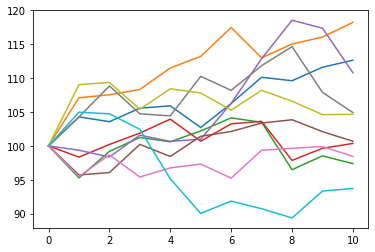

In [33]:
plt.plot(X.paths_exact(dW));

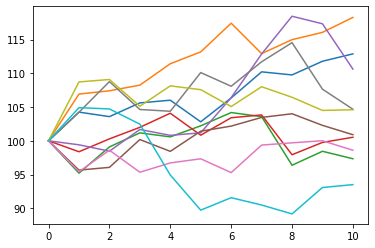

In [34]:
plt.plot(X.paths_euler(dW));

In [35]:
def strong_error(sde, scheme, steps, M = 10000):
    sdict = { "euler": sde.paths_euler, "milstein": sde.paths_milstein }
    result = []
    for N in steps:
        dW = np.sqrt(sde.T / N) * rng.standard_normal((N, M))
        exact_paths = X.paths_exact(dW)
        scheme_paths = sdict[scheme](dW)
        error = scheme_paths - exact_paths
        E = np.max(error**2, axis = 0)
        I_M = np.mean(E)
        size_IC_M = 1.96 * np.std(E) / np.sqrt(M)
        result.append([np.sqrt(I_M), np.sqrt(I_M-size_IC_M), np.sqrt(I_M+size_IC_M)])
    return np.array(result)

In [36]:
steps = 2**np.arange(1, 10)
res_euler = strong_error(X, "euler", steps, M = 1000)
res_milstein = strong_error(X, "milstein", steps, M = 1000)

In [44]:
res_euler

,"euler, N = 2","euler, N = 4","euler, N = 8","euler, N = 16","euler, N = 32","euler, N = 64","euler, N = 128"
Mean,21.097127,21.583397,21.863143,22.050434,22.114520,22.249133,22.164250
Var,497.251272,584.179536,630.786093,666.388700,674.819616,686.248791,687.918601
Lower bound,20.958918,21.433593,21.707479,21.890437,21.953514,22.086769,22.001689
Upper bound,21.235336,21.733200,22.018807,22.210431,22.275526,22.411496,22.326811


In [45]:
res_milstein

,"milstein, N = 2","milstein, N = 4","milstein, N = 8","milstein, N = 16","milstein, N = 32","milstein, N = 64","milstein, N = 128"
Mean,20.787191,21.318687,21.832871,21.916305,22.147480,22.205189,22.127773
Var,574.269241,618.578599,660.167596,676.884866,683.095455,698.967576,693.490184
Lower bound,20.638664,21.164536,21.673623,21.755053,21.985489,22.041328,21.964555
Upper bound,20.935718,21.472837,21.992120,22.077557,22.309470,22.369051,22.290991


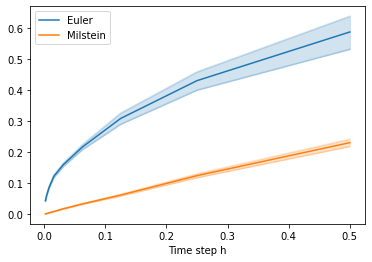

In [37]:
fig = plt.figure()
m = res_euler[:,0]
down = res_euler[:,1]
up = res_euler[:,2]

plt.plot(1/steps, m, color='C0', label='Euler')
plt.plot(1/steps, up, color='C0', alpha=0.2)
plt.plot(1/steps, down, color='C0', alpha=0.2)
plt.fill_between(1/steps, up, down, color='C0', alpha=0.2)

m = res_milstein[:,0]
down = res_milstein[:,1]
up = res_milstein[:,2]

plt.plot(1/steps, m, color='C1', label='Milstein')
plt.plot(1/steps, up, color='C1', alpha=0.2)
plt.plot(1/steps, down, color='C1', alpha=0.2)
plt.fill_between(1/steps, up, down, color='C1', alpha=0.2)

plt.xlabel('Time step h')
plt.legend()
plt.show()

### Estimation de l'erreur faible

In [38]:
def bs_call(X, K):
    d1 = (np.log(X.x0 / K) + (X.r + 0.5 * X.sigma ** 2) * X.T) / (X.sigma * np.sqrt(X.T))
    d2 = d1 - X.sigma * np.sqrt(X.T)
    
    price = X.x0 * sps.norm.cdf(d1) - K * np.exp(-X.r * X.T) * sps.norm.cdf(d2)   
    return price

In [39]:
def compute_call_bs(sde, scheme, steps, M = 10000):
    sdict = { "euler": sde.paths_euler, "milstein": sde.paths_milstein }
    result = None
    for N in steps:
        dW = np.sqrt(sde.T / N) * rng.standard_normal((N, M))
        paths = sdict[scheme](dW)
        payoffs = np.exp(-sde.r * sde.T)* np.maximum(paths[N] - K, 0)
        result = pd.concat([result, monte_carlo(payoffs, f'{scheme}, N = {N}')], axis = 1)
    return result

In [40]:
def monte_carlo(sample, name='', proba=0.95):
    mean = np.mean(sample)
    var = np.var(sample, ddof=1)
    quantile = sps.norm.ppf(1 - (1-proba)/2)
    ci_size = quantile * np.sqrt(var / sample.size)    
    result = pd.DataFrame(
        [mean, var, mean - ci_size, mean + ci_size], 
        index=("Mean","Var","Lower bound", "Upper bound"), 
        columns=[name])
    return result

In [41]:
X = BlackScholes(x0=100, r=0.2, sigma=0.3, T=1)
K = 100
exact_price = bs_call(X, K)

In [42]:
exact_price = bs_call(X, K)
print("Exact price:", exact_price)
M = int(1e5)
steps = 2**np.arange(1,8)
res_euler = compute_call_bs(X, "euler", steps, M=M)
res_milstein = compute_call_bs(X, "milstein", steps, M=M)

Exact price: 22.203501648326984


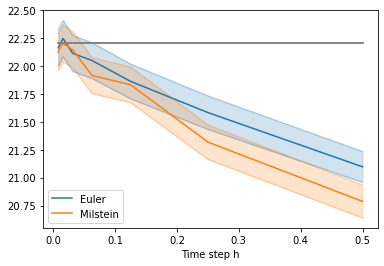

In [43]:
fig = plt.figure()
ress = [res_euler.values, res_milstein.values]
names = ['Euler', 'Milstein']
colors = ['C0', 'C1']
for res, name, color in zip(ress, names, colors):
    m, up, down = [res[0], res[2], res[3]]
    plt.plot(1/steps, m, color=color, label=name)
    plt.plot(1/steps, up, color=color, alpha=0.2)
    plt.plot(1/steps, down, color=color, alpha=0.2)
    plt.fill_between(1/steps, up, down, color=color, alpha=0.2)
    plt.plot(1/steps, exact_price*np.ones(len(steps)), color='grey')
plt.xlabel('Time step h')
plt.legend()
plt.show()